# Google Cloud & NCAA® ML Competition 2018-Men's

Kaggle Competition Notebook by Alex Herring, Ely Liu, Matthew Prout, Steve Yang

## Business Understanding
***

Business Understanding writeup here...





## Data Understanding
***

Data Understanding writeup here...

### EDA

EDA writeup here...

In [1]:
### EDA Analysis Here

## Data Preparation / Feature Engineering
***

### Data Preparation Challenges

We faced a number of challenges related to data preparation and feature engineering. Unlike many projects we've faced previously or a typical Kaggle competition, we had to make careful assumptions on what exactly would comprise the training dataset. One reason as apparent in the data understanding section was due to the sheer number of datasets provided for us. Three other primary reasons, made this process rather challenging.

First, the predictions were not based on features of that game itself. That is, it'd be rather useless if we used the features of a specific game to predict the outcome of that same game, since at prediction time that data would be unavailable. Thus, we had to engineer features that would be available to use at prediction time, making this a time-series forecasting problem in addition to simply a prediction problem.

The second challenge was keeping clear what feature would and would not be available at prediction time. There were a number of features that seemed great retrospectively, but we had to limit ourselves to features that would be available before the tournament began.

Finally, there were two main approaches to modeling, which caused challenges to the data preparation. Approach 1 involved using only the tournament results as the target variables, although it was still possible to engineer features that retained information about the regular season. The theory behind this approach was the hypothesis that regular season games and tournament games would be heterogenous. The implication of this approach were much fewer observations, but ones that would be more relevant to the prediction. Also, there were features that would not be possible to have if we trained based on regular season games -- primarily tournament seeds. Approach 2 took into account all regular season games. In this approach we theorized that tournament games were merely an extension of regular season games, and learning on the regular season could be used to predict the tournament results. The two approaches warranted slightly different logic for feature engineering, details of which are outlined below.

### Data Preparation Solutions

To handle some of the challenges, we set up a PostgreSQL instance of Google Cloud Platform to ensure we would be working with a single version of the truth. This was especially important because of the number of data sources and variations in features as mentioned above.

We build the canonical features table in which each row is one of the teams in every regular season or tournament game. In other words, there are two rows for every game, each row corresponding to one of two teams that play in that game. Each row also contains information about the opponent and features about the opponent, since how likely a team is to win a game is dependent just as much on the opponent they are facing. The target variable is, of course, game outcome represented as a binary variable. The modeling table begins with the 2003 season due to data quality issues before that time period for a number of raw data sources.

We create an extensive list of features -- some of which are simple aggregations of game statistics, and others based on more complex logic. The details of each feature can be found in this [document](http://www.google.com). There are some overarching patterns for the majority of the features.

First, most features are created in sets of three. That feature as it applies to the team, the opponent, and the difference between team and opponent. For example, for each row we would have the features "Two Point Percentage", "Opponent Two Point Percentage", and "Two Point Percentage Difference". 

Another nuance of feature engineering is that each feature is only compiled of information from preceding games from the season. Using "Two Point Percentage" as an example again. The feature is NaN in the first game of the season, since there is no preceding game. The second game of the season would be the metric from the previous game. For the third game of the season, the metric would be the aggregate from the first two games; and so on. For the tournament games, the feature is an aggregate of all games from the regular season. Described more concisely, we take cumulative aggregates of all metrics. This is to ensure that there is no data leakage.

In [197]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2 as pg
import csv

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Modeling - Approach 1
***

Approach 1 Explanation Here...

### Pull Features from PostgreSQL

Pull data from PostgreSQL and pickle to work offline.

In [3]:
# query = '''
#     SELECT *
#     FROM prod.features
#     WHERE "Season Type" = 'NCAA Tourney' and
#         holdout_s2 = 0
# '''

# conn = pg.connect(database='postgres',
#                   user='postgres',
#                   password='w207final',
#                   host='35.185.225.167')

# df = pd.read_sql_query(query, conn)

# # "Diff" Features
# df['AvgRankDiff'] = df['AvgRank'] - df['OpponentAvgRank']
# df['AvgNetPointsForDiff'] = df['AvgNetPointsFor'] - df['OpponentAvgNetPointsFor']
# df['TwoPointPctDiff'] = df['TwoPointPct_Team'] - df['TwoPointPct_Opponent']
# df['ThreePointPctDiff'] = df['ThreePointPct_Team'] - df['ThreePointPct_Opponent']
# df['FreeThrowPctDiff'] = df['FreeThrowPct_Team'] - df['FreeThrowPct_Opponent']
# df['OffensiveReboundsDiff'] = df['OffensiveRebounds_Team'] - df['OffensiveRebounds_Opponent']
# df['DefensiveReboundsDiff'] = df['DefensiveRebounds_Team'] - df['DefensiveRebounds_Opponent']
# df['FieldGoalPctDiff'] = df['FieldGoalPct_Team'] - df['FieldGoalPct_Opponent']
# df['TwoPointAttPctDiff'] = df['TwoPointAttPct_Team'] - df['TwoPointAttPct_Opponent']
# df['ThreePointAttPctDiff'] = df['ThreePointAttPct_Team'] - df['ThreePointAttPct_Opponent']
# df['FieldGoalAttDiff'] = df['FieldGoalAtt_Team'] - df['FieldGoalAtt_Opponent']
# df['TwoPointAttDiff'] = df['TwoPointAtt_Team'] - df['TwoPointAtt_Opponent']
# df['ThreePointAttDiff'] = df['ThreePointAtt_Team'] - df['ThreePointAtt_Opponent']
# df['FreeThrowAttDiff'] = df['FreeThrowAtt_Team'] - df['FreeThrowAtt_Opponent']
# df['AssistsDiff'] = df['Assists_Team'] - df['Assists_Opponent']
# df['TurnoversDiff'] = df['Turnovers_Team'] - df['Turnovers_Opponent']
# df['StealsDiff'] = df['Steals_Team'] - df['Steals_Opponent']
# df['BlocksDiff'] = df['Blocks_Team'] - df['Blocks_Opponent']
# df['PersonalFoulsDiff'] = df['PersonalFouls_Team'] - df['PersonalFouls_Opponent']

# # df.to_pickle("./modeling_df")

In [2]:
df_in = pd.read_pickle("./modeling_df")

In [3]:
df_train = df_in[df_in['holdout_s1'] == 0]
df_test = df_in[df_in['holdout_s1'] == 1]

### Baseline Metrics

- Log Loss value for all predicted probabilites == 0.5
- Log Loss value if every prediction was wrong with 100% confidence

In [4]:
target = 'Outcome'

# baseline of 0.5
baseline = np.full(536, 0.5)
print("Baseline: ",log_loss(df_test[target],baseline))

# worst case scenario -- every prediction was wrong with 100% confidence
print("Completely Wrong: ",log_loss(df_test[target],1-df_test[target]))

Baseline:  0.69314718056
Completely Wrong:  34.5391761936


In [5]:
target = 'Outcome'
features = ['SeedDiff']

lr = LogisticRegression()
lr.fit(df_train[features], df_train[target])
pred = lr.predict(df_test[features])
probs = lr.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.69      0.75      0.72       268
          1       0.73      0.67      0.70       268

avg / total       0.71      0.71      0.71       536

Log Loss:  0.571490292973
RMSE:  0.196131801918
ROC AUC:  0.770981844509


### Classifier Evaluation

#### Logistic Regression (Lasso)

In [6]:
target = 'Outcome'
features = ['SeedDiff',
            'WinPct', 'OpponentWinPct',
            'AvgNetPointsFor', 'OpponentAvgNetPointsFor',
            'AvgRank', 'OpponentAvgRank', 
            'TwoPointPct_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Team', 'ThreePointPct_Opponent',
            'FreeThrowPct_Team', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Team', 'OffensiveRebounds_Opponent',
            'DefensiveRebounds_Team', 'DefensiveRebounds_Opponent'
           ]

lr = LogisticRegression(penalty='l1')
lr.fit(df_train[features], df_train[target])
pred = lr.predict(df_test[features])
probs = lr.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.72      0.72      0.72       268
          1       0.72      0.72      0.72       268

avg / total       0.72      0.72      0.72       536

Log Loss:  0.544516760606
RMSE:  0.185242217929
ROC AUC:  0.793829360659


#### Logistic Regression (Ridge)

In [7]:
target = 'Outcome'
features = ['SeedDiff',
            'WinPct', 'OpponentWinPct',
            'AvgNetPointsFor', 'OpponentAvgNetPointsFor',
            'AvgRank', 'OpponentAvgRank', 
            'TwoPointPct_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Team', 'ThreePointPct_Opponent',
            'FreeThrowPct_Team', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Team', 'OffensiveRebounds_Opponent',
            'DefensiveRebounds_Team', 'DefensiveRebounds_Opponent'
           ]

lr = LogisticRegression(penalty='l2')
lr.fit(df_train[features], df_train[target])
pred = lr.predict(df_test[features])
probs = lr.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.72      0.72      0.72       268
          1       0.72      0.72      0.72       268

avg / total       0.72      0.72      0.72       536

Log Loss:  0.543489397983
RMSE:  0.184835817665
ROC AUC:  0.79476219648


#### Naive Bayes

In [9]:
target = 'Outcome'
features = ['SeedDiff',
            'WinPct', 'OpponentWinPct',
            'AvgNetPointsFor', 'OpponentAvgNetPointsFor',
            'AvgRank', 'OpponentAvgRank', 
            'TwoPointPct_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Team', 'ThreePointPct_Opponent',
            'FreeThrowPct_Team', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Team', 'OffensiveRebounds_Opponent',
            'DefensiveRebounds_Team', 'DefensiveRebounds_Opponent'
           ]

nb = GaussianNB()
nb.fit(df_train[features], df_train[target])

pred = nb.predict(df_test[features])
probs = nb.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.70      0.70      0.70       268
          1       0.70      0.70      0.70       268

avg / total       0.70      0.70      0.70       536

Log Loss:  0.918073498635
RMSE:  0.227348776469
ROC AUC:  0.767793495211


#### Decision Tree

In [10]:
target = 'Outcome'
features = ['SeedDiff',
            'WinPct', 'OpponentWinPct',
            'AvgNetPointsFor', 'OpponentAvgNetPointsFor',
            'AvgRank', 'OpponentAvgRank', 
            'TwoPointPct_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Team', 'ThreePointPct_Opponent',
            'FreeThrowPct_Team', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Team', 'OffensiveRebounds_Opponent',
            'DefensiveRebounds_Team', 'DefensiveRebounds_Opponent'
           ]

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(df_train[features], df_train[target])

pred = dt.predict(df_test[features])
probs = dt.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.64      0.70      0.67       268
          1       0.67      0.61      0.64       268

avg / total       0.66      0.66      0.66       536

Log Loss:  0.616227641986
RMSE:  0.211838082143
ROC AUC:  0.727417019381


#### Random Forest

In [11]:
target = 'Outcome'
features = ['SeedDiff',
            'WinPct', 'OpponentWinPct',
            'AvgNetPointsFor', 'OpponentAvgNetPointsFor',
            'AvgRank', 'OpponentAvgRank', 
            'TwoPointPct_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Team', 'ThreePointPct_Opponent',
            'FreeThrowPct_Team', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Team', 'OffensiveRebounds_Opponent',
            'DefensiveRebounds_Team', 'DefensiveRebounds_Opponent'
           ]

rf = RandomForestClassifier(n_estimators=300)
rf.fit(df_train[features], df_train[target])

pred = rf.predict(df_test[features])
probs = rf.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.67      0.66      0.67       268
          1       0.67      0.68      0.67       268

avg / total       0.67      0.67      0.67       536

Log Loss:  0.580489812936
RMSE:  0.199953503317
ROC AUC:  0.754552795723


#### Boosted Decision Classifier: XGBoost

In [29]:
import xgboost as xgb

target = 'Outcome'
features = ['SeedDiff', 'WinPct', 'OpponentWinPct', 'AvgNetPointsFor',
            'AvgRank', 'OpponentAvgRank', 
            'TwoPointPct_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Team', 'ThreePointPct_Opponent',
            'FreeThrowPct_Team', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Team', 'OffensiveRebounds_Opponent',
            'DefensiveRebounds_Team', 'DefensiveRebounds_Opponent'
           ]

gbm = xgb.XGBClassifier(n_estimators=300)
params = {'max_depth':[2,3,5,10,50], 'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.5]}
xgbClassifier = GridSearchCV(gbm, params, scoring='neg_log_loss', refit=True)
xgbClassifier.fit(df_train[features], df_train[target])

print('Best neg_log_loss: {:.4}, max_depth: {}, learning_rate: {}'.format(xgbClassifier.best_score_, xgbClassifier.best_params_['max_depth'], xgbClassifier.best_params_['learning_rate']))

pred = xgbClassifier.predict(df_test[features])
probs = xgbClassifier.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

Best neg_log_loss: -0.5516, max_depth: 3, learning_rate: 0.01
             precision    recall  f1-score   support

          0       0.69      0.69      0.69       268
          1       0.69      0.68      0.69       268

avg / total       0.69      0.69      0.69       536

('Log Loss: ', 0.58396462633260593)
('RMSE: ', 0.19982203443513188)
('ROC AUC: ', 0.75856259746045895)


#### Best Classifier

In comparing all results, Logistic Regression seesm to perform best, at least with the default parameters. In the next section, we proceed to further tune Logistic Regression

### Improvements to Logistic Regression

#### "Diff" Features

In [16]:
target = 'Outcome'
features = ['SeedDiff',
            'WinPctDiff',
            'AvgNetPointsForDiff',
            'AvgRankDiff', 
            'TwoPointPctDiff',
            'ThreePointPctDiff',
            'FreeThrowPctDiff',
            'OffensiveReboundsDiff',
            'DefensiveReboundsDiff'
           ]

lr = LogisticRegression(penalty='l2')
lr.fit(df_train[features], df_train[target])
pred = lr.predict(df_test[features])
probs = lr.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.72      0.72      0.72       268
          1       0.72      0.72      0.72       268

avg / total       0.72      0.72      0.72       536

Log Loss:  0.543233504514
RMSE:  0.184737569885
ROC AUC:  0.794664736021


#### Normalized Features

In [17]:
target = 'Outcome'
features = ['SeedDiff',
            'WinPctDiff',
            'AvgNetPointsForDiff',
            'AvgRankDiff', 
            'TwoPointPctDiff',
            'ThreePointPctDiff',
            'FreeThrowPctDiff',
            'OffensiveReboundsDiff',
            'DefensiveReboundsDiff'
           ]

# fit means/std
ss = StandardScaler()
ss.fit(df_train[features])

lr = LogisticRegression(penalty='l2')
lr.fit(ss.transform(df_train[features]), df_train[target])
pred = lr.predict(ss.transform(df_test[features]))
probs = lr.predict_proba(ss.transform(df_test[features]))

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.74      0.74      0.74       268
          1       0.74      0.74      0.74       268

avg / total       0.74      0.74      0.74       536

Log Loss:  0.546836443034
RMSE:  0.186142864184
ROC AUC:  0.79089162397


#### Normalized - More Features

In [20]:
target = 'Outcome'
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
            'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
            'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
            'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
            'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
            'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
            'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
            'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
            'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
            'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent',
            'AvgRankDiff', 'AvgNetPointsForDiff', 'TwoPointPctDiff',
            'ThreePointPctDiff', 'FreeThrowPctDiff', 'OffensiveReboundsDiff',
            'DefensiveReboundsDiff', 'FieldGoalPctDiff', 'TwoPointAttPctDiff',
            'ThreePointAttPctDiff', 'FieldGoalAttDiff', 'TwoPointAttDiff',
            'ThreePointAttDiff', 'FreeThrowAttDiff', 'AssistsDiff', 'TurnoversDiff',
            'StealsDiff', 'BlocksDiff', 'PersonalFoulsDiff']

# fit means/std
ss = StandardScaler()
ss.fit(df_train[features])

lr = LogisticRegression(penalty='l2')
lr.fit(ss.transform(df_train[features]), df_train[target])
pred = lr.predict(ss.transform(df_test[features]))
probs = lr.predict_proba(ss.transform(df_test[features]))

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.76      0.76      0.76       268
          1       0.76      0.76      0.76       268

avg / total       0.76      0.76      0.76       536

Log Loss:  0.529461957644
RMSE:  0.178672013288
ROC AUC:  0.808810425485


#### PCA + Logistic Regression

Transform features into the principal component space

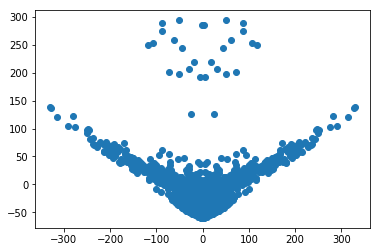

In [19]:
target = 'Outcome'
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
            'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
            'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
            'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
            'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
            'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
            'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
            'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
            'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
            'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent',
            'AvgRankDiff', 'AvgNetPointsForDiff', 'TwoPointPctDiff',
            'ThreePointPctDiff', 'FreeThrowPctDiff', 'OffensiveReboundsDiff',
            'DefensiveReboundsDiff', 'FieldGoalPctDiff', 'TwoPointAttPctDiff',
            'ThreePointAttPctDiff', 'FieldGoalAttDiff', 'TwoPointAttDiff',
            'ThreePointAttDiff', 'FreeThrowAttDiff', 'AssistsDiff', 'TurnoversDiff',
            'StealsDiff', 'BlocksDiff', 'PersonalFoulsDiff']

pca = PCA()
X_train_tr = pca.fit_transform(df_train[features])
X_test_tr = pca.transform(df_test[features])

plt.scatter(X_train_tr[:,0], X_train_tr[:,1])

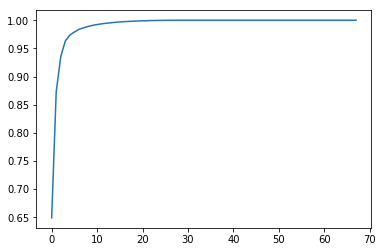

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [21]:
lr = LogisticRegression(penalty='l2')
lr.fit(X_train_tr[:, :10], df_train[target])
pred = lr.predict(X_test_tr[:, :10])
probs = lr.predict_proba(X_test_tr[:, :10])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.72      0.72      0.72       268
          1       0.72      0.72      0.72       268

avg / total       0.72      0.72      0.72       536

Log Loss:  0.530938704189
RMSE:  0.17980356067
ROC AUC:  0.804939852974


#### Parameter Tuning

In [51]:
target = 'Outcome'
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
            'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
            'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
            'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
            'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
            'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
            'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
            'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
            'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
            'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent',
            'AvgRankDiff', 'AvgNetPointsForDiff', 'TwoPointPctDiff',
            'ThreePointPctDiff', 'FreeThrowPctDiff', 'OffensiveReboundsDiff',
            'DefensiveReboundsDiff', 'FieldGoalPctDiff', 'TwoPointAttPctDiff',
            'ThreePointAttPctDiff', 'FieldGoalAttDiff', 'TwoPointAttDiff',
            'ThreePointAttDiff', 'FreeThrowAttDiff', 'AssistsDiff', 'TurnoversDiff',
            'StealsDiff', 'BlocksDiff', 'PersonalFoulsDiff']

# fit means/std
ss = StandardScaler()
ss.fit(df_train[features])

params = {'penalty': ['l1', 'l2'],
          'C': np.logspace(-4.0, 4.0, num=50)
         }

lr = LogisticRegression()
lr_gs = GridSearchCV(lr, params, scoring='neg_log_loss')

lr_gs.fit(ss.transform(df_train[features]), df_train[target])
pred = lr_gs.predict(ss.transform(df_test[features]))
probs = lr_gs.predict_proba(ss.transform(df_test[features]))

print(lr_gs.best_params_)
print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

{'C': 0.18420699693267145, 'penalty': 'l1'}
             precision    recall  f1-score   support

          0       0.74      0.74      0.74       268
          1       0.74      0.74      0.74       268

avg / total       0.74      0.74      0.74       536

Log Loss:  0.530934541743
RMSE:  0.179506005745
ROC AUC:  0.805622076186


### Evaluation over Baseline

Oddly enough, nothing produces better results than the default settings we tried with Logistic Regression earlier. That is with L2 Regularization and C = 1.0. This model produces an Log Loss score of 0.529, as compared to the baseline score of 0.693. 

## Modeling - Approach 2
***

The second approach to training and tuning the models is using the data from the regular season to train the model, and using the tournament data to tune the model.  An assumption with this approach is that we are treating the match up between regular season games and tournament games the same.

This approach has boths pros and cons.  One of the benefits to this approach is that many more observations to train from using the regular season games between 2003-2018 (82041) than just relying on the tournament games between 2003-2013 (713).  There are also daily rankings of division 1 teams provided by Massey Ratings which are apt for training with regular season games, although the ranking from the last regular season game can still be used with approach 1.  One of the main disadvantages to using approach 2 is that it cannot train on the tournament seed information, which is only available prior to the tournament.

Note that there are also variations for approach 2 that should be explored.  One variation is to use all the regular season games as training data, and all the tournament games as tuning data.  A second variation is to use the tournament data prior to 2014 with the regular season data for training, and the tournament data between 2014-2017 for tuning, similar to approach 1.  Both of these variations are examined below.

### Pull Features from PostgreSQL

Pull data from PostgreSQL and pickle to work offline.

In [21]:
conn = pg.connect(database='postgres',
                  user='postgres',
                  password='w207final',
                  host='35.185.225.167')

### Get the train/dev data from the database

#### Approach2: Training data is all regular season data (2003-2018)

In [22]:
approach2TrainingDataQuery = '''  SELECT * FROM prod."features" f WHERE (f."Season Type"='Regular') AND (f."Season" < 2019) ORDER BY "Season", "DayNum", "Team"  '''
df_approach2_training = pd.read_sql_query(approach2TrainingDataQuery, conn)

#### Approach2: Dev data is all tournament data (2003-2017)

In [23]:
approach2DevDataQuery = ''' SELECT * FROM prod."features" f WHERE (f."Season Type"='NCAA Tourney') AND (f."Season" > 2002) AND (f."Season" < 2018) order by "Season", "DayNum", "Team" '''
df_approach2_dev = pd.read_sql_query(approach2DevDataQuery, conn)

#### Approach2 Combined: Training data is all regular season data (2003-2018) and the tournament games before 2014 (2003-2013)

In [24]:
approach2CombinedTrainingDataQuery = '''  SELECT * FROM prod."features" f WHERE (f."Season Type"='Regular') OR (f."Season" < 2014) ORDER BY "Season", "DayNum", "Team"  '''
df_approach2Combined_training = pd.read_sql_query(approach2CombinedTrainingDataQuery, conn)

#### Approach2 Combined: Dev data is tournament data between 2014-2017

In [25]:
approach2CombinedDevDataQuery = ''' SELECT * FROM prod."features" f WHERE (f."Season Type"='NCAA Tourney') AND (f."Season" > 2013) AND (f."Season" < 2018) order by "Season", "DayNum", "Team" '''
df_approach2Combined_dev = pd.read_sql_query(approach2CombinedDevDataQuery, conn)

In [26]:
conn.close()

### Remove NaNs

In [27]:
columnsToClean = ['Outcome', 'AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins', 'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team', 'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team', 'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team', 'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team', 'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent', 'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent', 'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent', 'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent', 'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent']
df_approach2_training.dropna(how='any', inplace=True, subset=columnsToClean)
df_approach2_dev.dropna(how='any', inplace=True, subset=columnsToClean)
df_approach2Combined_training.dropna(how='any', inplace=True, subset=columnsToClean)
df_approach2Combined_dev.dropna(how='any', inplace=True, subset=columnsToClean)

### Create Train and Dev Sets

In [28]:
target = 'Outcome'
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins', 'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team', 'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team', 'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team', 'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team', 'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent', 'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent', 'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent', 'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent', 'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent']

In [29]:
X_train2 = df_approach2_training[features]
y_train2 = df_approach2_training[target]
X_dev2  = df_approach2_dev[features]
y_dev2  = df_approach2_dev[target]

In [30]:
X_train2_combined = df_approach2Combined_training[features]
y_train2_combined = df_approach2Combined_training[target]
X_dev2_combined  = df_approach2Combined_dev[features]
y_dev2_combined  = df_approach2Combined_dev[target]

#### Perform a Logistic Regression (Lasso) Using the **Regular Season**

In [16]:
lrc1 = LogisticRegression(penalty='l1')
params = {'C': [50,75,100,125,150,175,200,225]}
gscv1 = GridSearchCV(lrc1, params, scoring='neg_log_loss', refit=True)
gscv1.fit(X_train2, y_train2)
print('Best log-loss: {:.4}, with best C: {}'.format(gscv1.best_score_, gscv1.best_params_['C']))
lrc1 = LogisticRegression(penalty='l1', C=gscv1.best_params_['C'])
lrc1.fit(X_train2, y_train2)
prediction1 = lrc1.predict(X_dev2)
y_probas = lrc1.predict_proba(X_dev2)

Best log-loss: -0.5518, with best C: 75


In [17]:
# Determine F1 score
print(classification_report(prediction1, y_dev2))
# Determine AUC
print('Area under the curve: {0:.3f}'.format(roc_auc_score(y_dev2,  prediction1)))
# Determine log-loss
print('Log loss: {}'.format(log_loss(y_dev2.values, y_probas[:,1])))
# Determine RMSE
print('RMSE: {}'.format(mean_squared_error(y_dev2.values, y_probas[:,1])))

             precision    recall  f1-score   support

          0       0.73      0.73      0.73       981
          1       0.73      0.73      0.73       981

avg / total       0.73      0.73      0.73      1962

Area under the curve: 0.727
Log loss: 0.5474973854171304
RMSE: 0.1851080849969821


#### Perform a Logistic Regression (Ridge) Using the **Regular Season**

In [42]:
lrc2 = LogisticRegression(penalty='l2')
params = {'C': [50,75,100,125,150,175,200,225]}
gscv2 = GridSearchCV(lrc2, params, scoring='neg_log_loss', refit=True)
gscv2.fit(X_train2, y_train2)
print('Best log-loss: {:.4}, with best C: {}'.format(gscv2.best_score_, gscv2.best_params_['C']))
lrc2 = LogisticRegression(penalty='l2', C=gscv2.best_params_['C'])
lrc2.fit(X_train2, y_train2)
prediction2 = lrc2.predict(X_dev2)
y_probas = lrc2.predict_proba(X_dev2)

Best log-loss: -0.5518, with best C: 150


In [43]:
# Determine F1 score
print(classification_report(prediction2, y_dev2))
# Determine AUC
print('Area under the curve: {0:.3f}'.format(roc_auc_score(y_dev2,  prediction2)))
# Determine log-loss
print('Log loss: {}'.format(log_loss(y_dev2.values, y_probas[:,1])))
# Determine RMSE
print('RMSE: {}'.format(mean_squared_error(y_dev2.values, y_probas[:,1])))

             precision    recall  f1-score   support

          0       0.73      0.73      0.73       981
          1       0.73      0.73      0.73       981

avg / total       0.73      0.73      0.73      1962

Area under the curve: 0.728
Log loss: 0.547928193117
RMSE: 0.185320087108


#### Perform a Logistic Regression (Lasso) Using **Combined Regular Season / Tournament Data**

In [44]:
lrc3 = LogisticRegression(penalty='l1')
params = {'C': [50,75,100,125,150,175,200,225]}
gscv3 = GridSearchCV(lrc3, params, scoring='neg_log_loss', refit=True)
gscv3.fit(X_train2_combined, y_train2_combined)
print('Best log-loss: {:.4}, with best C: {}'.format(gscv3.best_score_, gscv3.best_params_['C']))
lrc3 = LogisticRegression(penalty='l1', C=gscv3.best_params_['C'])
lrc3.fit(X_train2_combined, y_train2_combined)
prediction3 = lrc3.predict(X_dev2_combined)
y_probas = lrc3.predict_proba(X_dev2_combined)

Best log-loss: -0.5518, with best C: 125


In [46]:
# Determine F1 score
print(classification_report(prediction3, y_dev2_combined))
# Determine AUC
print('Area under the curve: {0:.3f}'.format(roc_auc_score(y_dev2_combined,  prediction3)))
# Determine log-loss
print('Log loss: {}'.format(log_loss(y_dev2_combined.values, y_probas[:,1])))
# Determine RMSE
print('RMSE: {}'.format(mean_squared_error(y_dev2_combined.values, y_probas[:,1])))

             precision    recall  f1-score   support

          0       0.74      0.74      0.74       268
          1       0.74      0.74      0.74       268

avg / total       0.74      0.74      0.74       536

Area under the curve: 0.743
Log loss: 0.536772997951
RMSE: 0.180269404758


#### Perform a Logistic Regression (Ridge) Using **Combined Regular Season / Tournament Data**

In [18]:
lrc4 = LogisticRegression(penalty='l2')
params = {'C': [50,75,100,125,150,175,200,225]}
gscv4 = GridSearchCV(lrc4, params, scoring='neg_log_loss', refit=True)
gscv4.fit(X_train2_combined, y_train2_combined)
print('Best log-loss: {:.4}, with best C: {}'.format(gscv4.best_score_, gscv4.best_params_['C']))
lrc4 = LogisticRegression(penalty='l2', C=gscv4.best_params_['C'])
lrc4.fit(X_train2_combined, y_train2_combined)
prediction4 = lrc4.predict(X_dev2_combined)
y_probas = lrc4.predict_proba(X_dev2_combined)

Best log-loss: -0.5518, with best C: 50


In [19]:
# Determine F1 score
print(classification_report(prediction4, y_dev2_combined))
# Determine AUC
print('Area under the curve: {0:.3f}'.format(roc_auc_score(y_dev2_combined,  prediction4)))
# Determine log-loss
print('Log loss: {}'.format(log_loss(y_dev2_combined.values, y_probas[:,1])))
# Determine RMSE
print('RMSE: {}'.format(mean_squared_error(y_dev2_combined.values, y_probas[:,1])))

             precision    recall  f1-score   support

          0       0.74      0.74      0.74       268
          1       0.74      0.74      0.74       268

avg / total       0.74      0.74      0.74       536

Area under the curve: 0.743
Log loss: 0.5371935748903257
RMSE: 0.18048982712254258


### Best Data Set and Regularization

Based on the above models, the best results are from training a logistic regression model using a combination of regular season and tournament games (2003-2013), and using lasso regression (L1) for regularization.

## Model Ensemble
***

Rather than just using approach 1 or approach 2, it is possible to combine the two approaches into an ensemble.

The ensemble used here trains approach 1 using the tournament data (prior to 2014), and approach 2 using the combined regular season / tournament data as described above.

Then predictions are made using the tournament data from 2014-207, as this is common between the two approaches (but note that the SeedDiff feature is not used with approach 2).

The probabilities for winning from both approaches are averaged, and so are the probabilities for losing.

After averaging the probabilities, the winning and losing probabilities are then compared to see which probability is greater.  The greater probability determines the predicted outcome of the game.

In [32]:
# target = 'Outcome'
# features2 = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
#             'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
#             'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
#             'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
#             'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
#             'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
#             'AvgNetPointsFor', 'OpponentAvgPointsFor',
#             'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
#             'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
#             'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
#             'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
#             'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
#             'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
#             'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
#             'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
#             'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
#             'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent']
# features1 = features2 + ['SeedDiff']

### Train Approach 1

In [64]:
target = 'Outcome'
features1 = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
            'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
            'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
            'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
            'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
            'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
            'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
            'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
            'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
            'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent',
            'AvgRankDiff', 'AvgNetPointsForDiff', 'TwoPointPctDiff',
            'ThreePointPctDiff', 'FreeThrowPctDiff', 'OffensiveReboundsDiff',
            'DefensiveReboundsDiff', 'FieldGoalPctDiff', 'TwoPointAttPctDiff',
            'ThreePointAttPctDiff', 'FieldGoalAttDiff', 'TwoPointAttDiff',
            'ThreePointAttDiff', 'FreeThrowAttDiff', 'AssistsDiff', 'TurnoversDiff',
            'StealsDiff', 'BlocksDiff', 'PersonalFoulsDiff']

ss = StandardScaler()
ss.fit(df_train[features1])

lr1 = LogisticRegression(penalty='l2')
lr1.fit(ss.transform(df_train[features1]), df_train[target])

# fit on common dev data
pred1 = lr1.predict(ss.transform(df_test[features1]))
probs1 = lr1.predict_proba(ss.transform(df_test[features1]))

print(classification_report(df_test[target], pred1))
print("Log Loss: ",log_loss(df_test[target], probs1[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs1[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs1[:,1]))

             precision    recall  f1-score   support

          0       0.76      0.76      0.76       268
          1       0.76      0.76      0.76       268

avg / total       0.76      0.76      0.76       536

Log Loss:  0.529461957644
RMSE:  0.178672013288
ROC AUC:  0.808810425485


### Train Approach 2

In [65]:
target = 'Outcome'
features2 = list(X_dev2_combined.columns)

lr2 = LogisticRegression(penalty='l1', C=125)
lr2.fit(X_train2_combined, y_train2_combined)

# fit on common dev data
pred2 = lr2.predict(df_test[features2])
probs2 = lr2.predict_proba(df_test[features2])

print(classification_report(df_test[target], pred2))
print("Log Loss: ",log_loss(df_test[target], probs2[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs2[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs2[:,1]))

             precision    recall  f1-score   support

          0       0.74      0.74      0.74       268
          1       0.74      0.74      0.74       268

avg / total       0.74      0.74      0.74       536

Log Loss:  0.536758492226
RMSE:  0.180263171259
ROC AUC:  0.811205168189


### Simple Ensemble of Approach 1 and Approach 2

In [66]:
# Get the mean of the loss probabilities and the win probabilities
loss_prob_df = pd.DataFrame(data={'approach1':probs1[:,0], 'approach2':probs2[:,0]})
win_prob_df = pd.DataFrame(data={'approach1':probs1[:,1], 'approach2':probs2[:,1]})
loss_win_df = pd.DataFrame(data={'loss_prob':loss_prob_df.mean(axis=1), 'win_prob':win_prob_df.mean(axis=1), 'predict':0})

In [67]:
# Determine loss / win depending on which probability is larger
ensemble_predictions = []
ensemble_probs = []

for index in range(len(win_prob_df)):
    if loss_win_df['loss_prob'][index] > loss_win_df['win_prob'][index] :
        ensemble_predictions.append(0)
        ensemble_probs.append(1-loss_win_df['loss_prob'][index])
    else:
        ensemble_predictions.append(1)
        ensemble_probs.append(loss_win_df['win_prob'][index])

In [68]:
print(classification_report(df_test[target], ensemble_predictions))
print("Log Loss: ",log_loss(df_test[target], ensemble_probs))
print("RMSE: ",mean_squared_error(df_test[target], ensemble_probs))
print("ROC AUC: ", roc_auc_score(df_test[target], ensemble_probs))

             precision    recall  f1-score   support

          0       0.75      0.75      0.75       268
          1       0.75      0.75      0.75       268

avg / total       0.75      0.75      0.75       536

Log Loss:  0.523652468758
RMSE:  0.175790465405
ROC AUC:  0.815994653598


### Weighted Ensemble with Logistic Regression

In [124]:
# df_ens_dev, df_ens_test = train_test_split(df_test)
df_ens_dev = df_test[df_test['Season'] < 2017]
df_ens_test = df_test[df_test['Season'] == 2017]

# fit ens_dev
# a1
pred1_ens_dev = lr1.predict(ss.transform(df_ens_dev[features1]))
probs1_ens_dev = lr1.predict_proba(ss.transform(df_ens_dev[features1]))

# a2
pred2_ens_dev = lr2.predict(df_ens_dev[features2])
probs2_ens_dev = lr2.predict_proba(df_ens_dev[features2])

# prediction probabilities into features
X_ens_dev = np.asarray((probs1_ens_dev[:, 1],probs2_ens_dev[:, 1])).T

# fit ens_dev prediction probs
ens1 = LogisticRegression()
ens1.fit(X_ens_dev, df_ens_dev[target])

# fit ens_test
# a1
pred1_ens_test = lr1.predict(ss.transform(df_ens_test[features1]))
probs1_ens_test = lr1.predict_proba(ss.transform(df_ens_test[features1]))

# a2
pred2_ens_test = lr2.predict(df_ens_test[features2])
probs2_ens_test = lr2.predict_proba(df_ens_test[features2])

# prediction probabilities into features
X_ens_test = np.asarray((probs1_ens_test[:, 1],probs2_ens_test[:, 1])).T

# predict ens_test probabilities
pred_fin = ens1.predict(X_ens_test)
probs_fin = ens1.predict_proba(X_ens_test)

print(classification_report(df_ens_test[target], pred_fin))
print("Log Loss: ",log_loss(df_ens_test[target], probs_fin[:,1]))
print("RMSE: ",mean_squared_error(df_ens_test[target], probs_fin[:,1]))
print("ROC AUC: ", roc_auc_score(df_ens_test[target], probs_fin[:,1]))

             precision    recall  f1-score   support

          0       0.77      0.76      0.77        67
          1       0.76      0.78      0.77        67

avg / total       0.77      0.77      0.77       134

Log Loss:  0.515845272942
RMSE:  0.171587089873
ROC AUC:  0.828469592337


## Final Model Evaluation (2018 Tournament)
***

### Pull All Potential 2018 Matchups

This includes both games that did and did not actually occur. Using the top performing methods, data will be retrained using both training and dev data from the earlier section and finally tested on 2018 data. Final results were not shared in tabular form from Kaggle, since the competition ended. Data was [scraped](http://www.google.com) from NCAA website.

In [128]:
# pull 2018 potential matchups
query = '''
    SELECT *
    FROM prod.features
    WHERE "Season Type" = 'NCAA Tourney' and
        holdout_s2 = 1
'''

conn = pg.connect(database='postgres',
                  user='postgres',
                  password='w207final',
                  host='35.185.225.167')

df_2018 = pd.read_sql_query(query, conn)

# "Diff" Features
df_2018['AvgRankDiff'] = df_2018['AvgRank'] - df_2018['OpponentAvgRank']
df_2018['AvgNetPointsForDiff'] = df_2018['AvgNetPointsFor'] - df_2018['OpponentAvgNetPointsFor']
df_2018['TwoPointPctDiff'] = df_2018['TwoPointPct_Team'] - df_2018['TwoPointPct_Opponent']
df_2018['ThreePointPctDiff'] = df_2018['ThreePointPct_Team'] - df_2018['ThreePointPct_Opponent']
df_2018['FreeThrowPctDiff'] = df_2018['FreeThrowPct_Team'] - df_2018['FreeThrowPct_Opponent']
df_2018['OffensiveReboundsDiff'] = df_2018['OffensiveRebounds_Team'] - df_2018['OffensiveRebounds_Opponent']
df_2018['DefensiveReboundsDiff'] = df_2018['DefensiveRebounds_Team'] - df_2018['DefensiveRebounds_Opponent']
df_2018['FieldGoalPctDiff'] = df_2018['FieldGoalPct_Team'] - df_2018['FieldGoalPct_Opponent']
df_2018['TwoPointAttPctDiff'] = df_2018['TwoPointAttPct_Team'] - df_2018['TwoPointAttPct_Opponent']
df_2018['ThreePointAttPctDiff'] = df_2018['ThreePointAttPct_Team'] - df_2018['ThreePointAttPct_Opponent']
df_2018['FieldGoalAttDiff'] = df_2018['FieldGoalAtt_Team'] - df_2018['FieldGoalAtt_Opponent']
df_2018['TwoPointAttDiff'] = df_2018['TwoPointAtt_Team'] - df_2018['TwoPointAtt_Opponent']
df_2018['ThreePointAttDiff'] = df_2018['ThreePointAtt_Team'] - df_2018['ThreePointAtt_Opponent']
df_2018['FreeThrowAttDiff'] = df_2018['FreeThrowAtt_Team'] - df_2018['FreeThrowAtt_Opponent']
df_2018['AssistsDiff'] = df_2018['Assists_Team'] - df_2018['Assists_Opponent']
df_2018['TurnoversDiff'] = df_2018['Turnovers_Team'] - df_2018['Turnovers_Opponent']
df_2018['StealsDiff'] = df_2018['Steals_Team'] - df_2018['Steals_Opponent']
df_2018['BlocksDiff'] = df_2018['Blocks_Team'] - df_2018['Blocks_Opponent']
df_2018['PersonalFoulsDiff'] = df_2018['PersonalFouls_Team'] - df_2018['PersonalFouls_Opponent']

df_2018.shape

(4556, 83)

Filter to only games that occurred for testing.

In [127]:
df_test_2018 = df_2018[df_2018['Outcome'].notnull()]
print(df_test_2018.shape)

(134, 83)


### Baseline

Just to reground ourselves -- these are the log-loss scores for the baseline.

In [130]:
target = 'Outcome'

# baseline of 0.5
baseline = np.full(134, 0.5)
print("Baseline: ",log_loss(df_test_2018[target],baseline))

# worst case scenario -- every prediction was wrong with 100% confidence
print("Completely Wrong: ",log_loss(df_test_2018[target],1-df_test_2018[target]))

Baseline:  0.69314718056
Completely Wrong:  34.5391761936


### Best Approach 1

Logistic Regression with L2 Regularization and C = 1.0

In [131]:
target = 'Outcome'
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
            'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
            'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
            'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
            'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
            'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
            'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
            'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
            'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
            'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent',
            'AvgRankDiff', 'AvgNetPointsForDiff', 'TwoPointPctDiff',
            'ThreePointPctDiff', 'FreeThrowPctDiff', 'OffensiveReboundsDiff',
            'DefensiveReboundsDiff', 'FieldGoalPctDiff', 'TwoPointAttPctDiff',
            'ThreePointAttPctDiff', 'FieldGoalAttDiff', 'TwoPointAttDiff',
            'ThreePointAttDiff', 'FreeThrowAttDiff', 'AssistsDiff', 'TurnoversDiff',
            'StealsDiff', 'BlocksDiff', 'PersonalFoulsDiff']

# fit means/std
ss = StandardScaler()
ss.fit(df_in[features])

lr = LogisticRegression(penalty='l2')
lr.fit(ss.transform(df_in[features]), df_in[target])

pred = lr.predict(ss.transform(df_test_2018[features]))
probs = lr.predict_proba(ss.transform(df_test_2018[features]))

print(classification_report(df_test_2018[target], pred))
print("Log Loss: ",log_loss(df_test_2018[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test_2018[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test_2018[target], probs[:,1]))

             precision    recall  f1-score   support

        0.0       0.70      0.70      0.70        67
        1.0       0.70      0.70      0.70        67

avg / total       0.70      0.70      0.70       134

Log Loss:  0.609581060519
RMSE:  0.201148927619
ROC AUC:  0.761639563377


### Best Approach 2

In [145]:
target = 'Outcome'
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent',
            'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent',
            'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst',
            'OpponentAvgNetPointsFor', 'TourWins', 'OpponentTourWins', 'TourWinsDiff',
            'FieldGoalPct_Team', 'TwoPointAttPct_Team', 'ThreePointAttPct_Team',
            'FieldGoalAtt_Team', 'TwoPointAtt_Team', 'ThreePointAtt_Team', 'FreeThrowAtt_Team',
            'Assists_Team', 'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent', 'ThreePointAttPct_Opponent',
            'FieldGoalAtt_Opponent', 'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent', 'Steals_Opponent',
            'Blocks_Opponent', 'PersonalFouls_Opponent']

X_train2_final = np.concatenate((X_train2_combined, X_dev2_combined))
y_train2_final = np.concatenate((y_train2_combined, y_dev2_combined))

lr2 = LogisticRegression(penalty='l1', C=125)
lr2.fit(X_train2_final, y_train2_final)

# fit on common dev data
pred2 = lr2.predict(df_test_2018[features])
probs2 = lr2.predict_proba(df_test_2018[features])

print(classification_report(df_test_2018[target], pred2))
print("Log Loss: ",log_loss(df_test_2018[target], probs2[:,1]))
print("RMSE: ",mean_squared_error(df_test_2018[target], probs2[:,1]))
print("ROC AUC: ", roc_auc_score(df_test_2018[target], probs2[:,1]))

             precision    recall  f1-score   support

        0.0       0.63      0.63      0.63        67
        1.0       0.63      0.63      0.63        67

avg / total       0.63      0.63      0.63       134

Log Loss:  0.58819540517
RMSE:  0.203892308624
ROC AUC:  0.746045889953


### Simple Ensemble

In [146]:
# Get the mean of the loss probabilities and the win probabilities
loss_prob_df = pd.DataFrame(data={'approach1':probs[:,0],
                                  'approach2':probs2[:,0]
                                 })
win_prob_df = pd.DataFrame(data={'approach1':probs[:,1],
                                 'approach2':probs2[:,1]
                                })
loss_win_df = pd.DataFrame(data={'loss_prob':loss_prob_df.mean(axis=1),
                                 'win_prob':win_prob_df.mean(axis=1),
                                 'predict':0
                                })

# Determine loss / win depending on which probability is larger
ensemble_predictions = []
ensemble_probs = []

for index in range(len(win_prob_df)):
    if loss_win_df['loss_prob'][index] > loss_win_df['win_prob'][index] :
        ensemble_predictions.append(0)
        ensemble_probs.append(1-loss_win_df['loss_prob'][index])
    else:
        ensemble_predictions.append(1)
        ensemble_probs.append(loss_win_df['win_prob'][index])
        
print(classification_report(df_test_2018[target], ensemble_predictions))
print("Log Loss: ",log_loss(df_test_2018[target], ensemble_probs))
print("RMSE: ",mean_squared_error(df_test_2018[target], ensemble_probs))
print("ROC AUC: ", roc_auc_score(df_test_2018[target], ensemble_probs))

             precision    recall  f1-score   support

        0.0       0.67      0.67      0.67        67
        1.0       0.67      0.67      0.67        67

avg / total       0.67      0.67      0.67       134

Log Loss:  0.587896342483
RMSE:  0.200916557467
ROC AUC:  0.75762976164


### Weighted Ensemble

For each approach, data needs to be split into three groups.

1. Training
2. Ensemble Training
3. Test (2018)

Ensemble Training data examples must be homogenous between approach 1 and approach 2, although this is not necessarily the case for the first stage of training. There are simply two features in Ensemble Training, predicted probabilities from each approach.

#### Split Data

In [184]:
# combine dev/train for approach 2
# approach1 is pulled in together
df_train_a2 = pd.concat((df_approach2Combined_training, df_approach2Combined_dev))

# first level training
df_train1_a1 = df_in[df_in['Season'] < 2017]
df_train1_a2 = df_train_a2[(df_train_a2['Season Type'] == 'Regular') | (df_train_a2['Season'] < 2017)]

# second level training -- same dataset for both approaches
df_train2 = df_in[df_in['Season'] == 2017]

# Just to check observations
df_train1_a2 = df_train_a2[(df_train_a2['Season Type'] == 'Regular') | (df_train_a2['Season'] < 2017)]
df_train2_a2 = df_train_a2[(df_train_a2['Season Type'] == 'NCAA Tourney') & (df_train_a2['Season'] == 2017)]

print(df_train1_a1.shape)
print(df_train2.shape)
print(df_train1_a2.shape)
print(df_train2_a2.shape)
print(df_test_2018.shape)


(1828, 83)
(134, 83)
(154722, 64)
(134, 64)
(134, 83)


#### Fit Approach 1

In [185]:
target = 'Outcome'
features1 = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
            'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
            'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
            'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
            'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
            'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
            'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
            'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
            'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
            'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent',
            'AvgRankDiff', 'AvgNetPointsForDiff', 'TwoPointPctDiff',
            'ThreePointPctDiff', 'FreeThrowPctDiff', 'OffensiveReboundsDiff',
            'DefensiveReboundsDiff', 'FieldGoalPctDiff', 'TwoPointAttPctDiff',
            'ThreePointAttPctDiff', 'FieldGoalAttDiff', 'TwoPointAttDiff',
            'ThreePointAttDiff', 'FreeThrowAttDiff', 'AssistsDiff', 'TurnoversDiff',
            'StealsDiff', 'BlocksDiff', 'PersonalFoulsDiff']

# fit means/std
ss = StandardScaler()
ss.fit(df_train1_a1[features1])

lr1 = LogisticRegression(penalty='l2')
lr1.fit(ss.transform(df_train1_a1[features1]), df_train1_a1[target])

# predict "dev"
pred1 = lr.predict(ss.transform(df_train2[features1]))
probs1 = lr.predict_proba(ss.transform(df_train2[features1]))

# predict on "2018 test"
pred1_2018 = lr.predict(ss.transform(df_test_2018[features1]))
probs1_2018 = lr.predict_proba(ss.transform(df_test_2018[features1]))

#### Fit Approach 2

In [181]:
target = 'Outcome'
features2 = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent',
            'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent',
            'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst',
            'OpponentAvgNetPointsFor', 'TourWins', 'OpponentTourWins', 'TourWinsDiff',
            'FieldGoalPct_Team', 'TwoPointAttPct_Team', 'ThreePointAttPct_Team',
            'FieldGoalAtt_Team', 'TwoPointAtt_Team', 'ThreePointAtt_Team', 'FreeThrowAtt_Team',
            'Assists_Team', 'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent', 'ThreePointAttPct_Opponent',
            'FieldGoalAtt_Opponent', 'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent', 'Steals_Opponent',
            'Blocks_Opponent', 'PersonalFouls_Opponent']

lr2 = LogisticRegression(penalty='l1', C=125)
lr2.fit(df_train1_a2[features2], df_train1_a2[target])

# predict "dev"
pred2 = lr2.predict(df_train2[features2])
probs2 = lr2.predict_proba(df_train2[features2])

# predict "2018 test"
pred2_2018 = lr2.predict(df_test_2018[features2])
probs2_2018 = lr2.predict_proba(df_test_2018[features2])

#### Fit Weighted Ensemble

In [183]:
# ensemble features
X_ens_train = np.asarray((probs1[:, 1],probs2[:, 1])).T
X_ens_2018 = np.asarray((probs1_2018[:, 1],probs2_2018[:, 1])).T

# fit ensemble features
ens1 = LogisticRegression()
ens1.fit(X_ens_train, df_train2[target])

# predict 2018
pred_ens = ens1.predict(X_ens_2018)
probs_ens = ens1.predict_proba(X_ens_2018)

print(classification_report(df_test_2018[target], pred_ens))
print("Log Loss: ",log_loss(df_test_2018[target], probs_ens[:,1]))
print("RMSE: ",mean_squared_error(df_test_2018[target], probs_ens[:,1]))
print("ROC AUC: ", roc_auc_score(df_test_2018[target], probs_ens[:,1]))

             precision    recall  f1-score   support

        0.0       0.67      0.67      0.67        67
        1.0       0.67      0.67      0.67        67

avg / total       0.67      0.67      0.67       134

Log Loss:  0.58410907089
RMSE:  0.199951894606
ROC AUC:  0.75696146135


## Model Deployment
***

- Create prediction output of all possible games
- Submit CSV to Kaggle

Final predictions on all potential matchups, instead of only observed games.

In [196]:
# final predictions
probs1_final = lr.predict_proba(ss.transform(df_2018[features1]))
probs2_final = lr2.predict_proba(df_2018[features2])
X_ens_final = np.asarray((probs1_final[:, 1],probs2_final[:, 1])).T
probs_ens_final = ens1.predict_proba(X_ens_final)

(4556, 2)

In [198]:
out = df_2018[['Season', 'Team', 'Opponent']].copy()
out['Pred'] = probs_ens_final[:, 1]
out2 = out[out['Team'] < out['Opponent']]

datarows = []
for i in out2.itertuples(index=False):
    row = ("_".join([str(i.Season), str(i.Team), str(i.Opponent)]), float(i.Pred))
    datarows.append(row)

with open('./model_deployment.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['ID','Pred'])
    for row in datarows:
        csv_out.writerow(row)

In [211]:
out = df_2018[['Season', 'Team', 'Opponent']].copy()
out['Pred'] = probs_ens_final[:, 1]

out_test1 = out[out['Team'] < out['Opponent']]
out_test2 = out[out['Team'] > out['Opponent']]

out_test1[(out_test1['Team'] == 1437)]

,Season,Team,Opponent,Pred
90,2018,1437,1452,0.592071
4157,2018,1437,1438,0.577763
4158,2018,1437,1439,0.769941
4159,2018,1437,1455,0.706788
4160,2018,1437,1460,0.845817
4161,2018,1437,1462,0.678779


In [208]:
out_test2[(out_test2['Opponent'] == 1104)]

,Season,Team,Opponent,Pred
85,2018,1437,1104,0.781100
92,2018,1439,1104,0.552062
198,2018,1112,1104,0.743798
264,2018,1113,1104,0.553457
330,2018,1116,1104,0.599123
396,2018,1120,1104,0.686473
461,2018,1137,1104,0.359350
527,2018,1138,1104,0.409440
592,2018,1139,1104,0.677553
657,2018,1153,1104,0.776792
